In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from sklearn import metrics
import os
import pickle

In [2]:
merged_df = pd.read_csv("../../filtered_dataset/train/selected_instance_0.csv", index_col='timestamp')
merged_df = merged_df[:150000]

In [3]:
merged_data_class = merged_df['class']

merged_data_np = merged_df.drop('class', axis=1).values

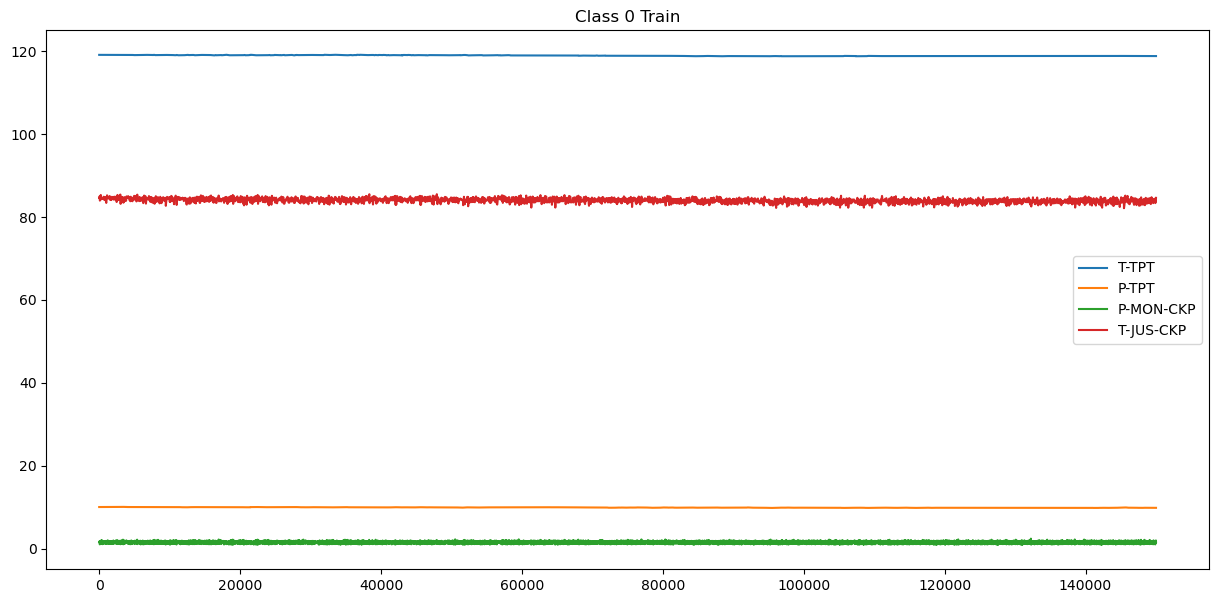

In [4]:
plt.figure(figsize=(15,7))
plt.plot(merged_data_np)
plt.legend(['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP'])
plt.title("Class 0 Train")
plt.show()

In [5]:
dataset_dir = "../../datasets/3W/dataset/2"
list_files = ["SIMULATED_00001.parquet","SIMULATED_00002.parquet","SIMULATED_00003.parquet"]

merged_df_test = pd.DataFrame(columns=['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class'])
for files in list_files:
    df = pd.read_parquet(os.path.join(dataset_dir, files))
    df = df[['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class']]
    merged_df_test = pd.concat([merged_df_test, df])
# merged_df_test = pd.read_parquet(dataset_dir)
# merged_df_test = merged_df_test[['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG', 'class']]

# Scale pressure columns (those starting with 'P') by 10^6
pressure_columns = [col for col in merged_df_test.columns if col.startswith('P')]
merged_df_test[pressure_columns] = merged_df_test[pressure_columns] / 10**6    

/tmp/ipykernel_36315/590388463.py:8: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  merged_df_test = pd.concat([merged_df_test, df])
/tmp/ipykernel_36315/590388463.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df_test = pd.concat([merged_df_test, df])


In [6]:
merged_data_test_class = merged_df_test['class']
merged_data_test_np = merged_df_test.drop('class', axis=1).values

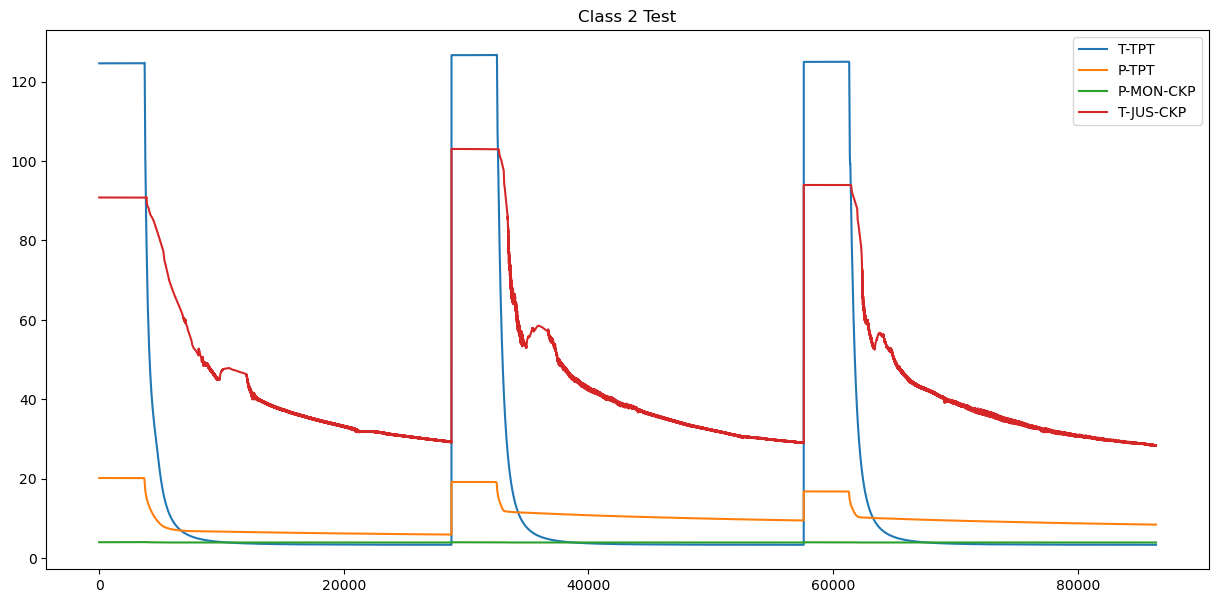

In [7]:
plt.figure(figsize=(15,7))
plt.plot(merged_data_test_np)
plt.legend(['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP'])
plt.title("Class 2 Test")
plt.show()

## Gaussian Distribution

In [8]:
mu, std = norm.fit(merged_data_np)                          # Fit a normal distribution
print("Mu and Std: ", mu, std)

Mu and Std:  53.60158842114319 49.493655661867514


Confidence Interval:  (-43.40419413934407, 150.60737098163045)


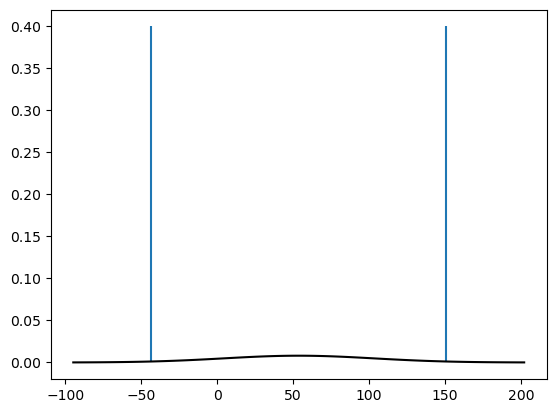

In [ ]:
CI_95 = norm.interval(0.95, loc=mu, scale=std)    # Find the 95% CI endpoints
print("Confidence Interval: ", CI_95)

plt.vlines(CI_95, ymin=0, ymax=0.4)               # plotting stuff
x = np.linspace(mu - 3*std, mu + 3*std, 100)
plt.plot(x, norm.pdf(x, mu, std), color='black')
plt.show()

In [10]:
norm.pdf(merged_data_np, mu, std).shape

(150000, 4)

In [11]:
p_val = norm.pdf(merged_data_test_np, mu, std)

In [12]:
p_val.shape

(86397, 4)

In [13]:
def select_threshold(y_val, p_val): 
    """
    Finds the best threshold to use for selecting outliers 
    based on the results from a validation set (p_val) 
    and the ground truth (y_val)
    
    Args:
        y_val (ndarray): Ground truth on validation set
        p_val (ndarray): Results on validation set
        
    Returns:
        epsilon (float): Threshold chosen 
        acc (float):      acc score by choosing epsilon as threshold
    """ 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (np.max(p_val) - np.min(p_val)) / 1000
    
    for epsilon in np.arange(np.min(p_val), np.max(p_val), step_size):
    
        ### START CODE HERE ### 
        predictions = np.max(np.where((p_val < epsilon), 1, 0), axis=1)
        
        tp = np.sum((predictions == 1) & (y_val == 1))
        tn = np.sum((predictions == 0) & (y_val == 0))
        fp = np.sum((predictions == 1) & (y_val == 0))
        fn = np.sum((predictions == 0) & (y_val == 1))
        
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        
        # acc = (tp + tn) / (tp + tn + fp + fn)
        # acc = 0.5 * ((tp / (tp + fn)) + (tn / (tn + fp)))
        F1 = 2 * (prec * rec) / (prec + rec)
        ### END CODE HERE ### 
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1, predictions

In [14]:
epsilon, acc, pred = select_threshold(merged_data_test_class.astype(bool).astype(int), p_val)

/tmp/ipykernel_36315/2144130704.py:32: RuntimeWarning: invalid value encountered in scalar divide
  prec = tp / (tp + fp)


In [15]:
print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % acc)

Best epsilon found using cross-validation: 4.890514e-03
Best  on Cross Validation Set: 0.933331


In [16]:
print("Accuracy: ", metrics.accuracy_score(np.array(merged_data_test_class).astype(bool), pred))
print("F1-score: ", metrics.f1_score(np.array(merged_data_test_class).astype(bool), pred))

Accuracy:  0.8749956595715129
F1-score:  0.933330864106078


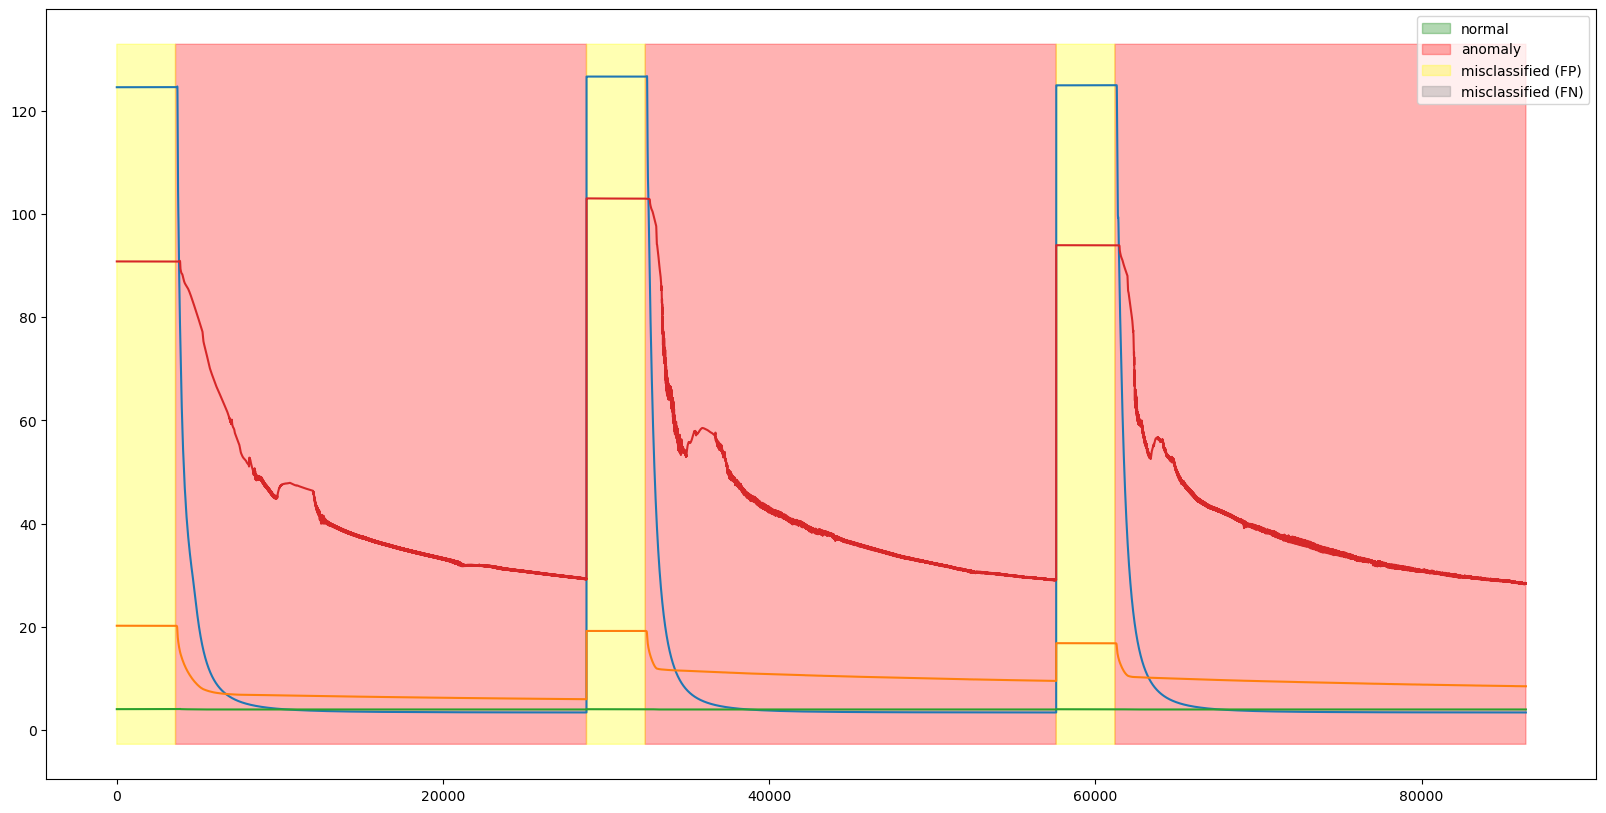

In [17]:
plt.figure(figsize=(20,10))
plt.plot(merged_data_test_np)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0,len(merged_data_test_np)), ymax, ymin, where=((~merged_data_test_class.astype(bool)) & (~pred)), color='green', alpha=0.3, label='normal')
plt.fill_between(np.arange(0,len(merged_data_test_np)), ymax, ymin,where=((merged_data_test_class.astype(bool)) & (pred)), color='red', alpha=0.3, label='anomaly')
plt.fill_between(np.arange(0,len(merged_data_test_np)), ymax, ymin,where=(~merged_data_test_class.astype(bool) & pred ), color='yellow', alpha=0.3, label='misclassified (FP)')
plt.fill_between(np.arange(0,len(merged_data_test_np)), ymax, ymin,where=(merged_data_test_class.astype(bool) & ~pred ), color='gray', alpha=0.3, label='misclassified (FN)')
# plt.legend(['P-PDG','P-TPT', 'T-TPT','P-PDG_rec','P-TPT_rec', 'T-TPT_rec','normal','anomaly','missclasiffied (FP)','missclasiffied (FN)'])
plt.legend()

## Local Outlier Factor

In [18]:
from sklearn.neighbors import LocalOutlierFactor

scaler = pickle.load(open('StandardScaler-3W-0-filtered.pkl', 'rb'))
merged_data_np_scaled = scaler.transform(merged_data_np)

lof = LocalOutlierFactor(novelty=True)
lof.fit(merged_data_np_scaled)

LocalOutlierFactor(novelty=True)

In [19]:
scaler_test = pickle.load(open('StandardScaler-3W-2-filtered.pkl', 'rb'))
merged_data_test_np_scaled = scaler_test.transform(merged_data_test_np)

pred = lof.predict(merged_data_test_np_scaled)
pred = np.where((pred == 1), 0, 1)

In [20]:
print("Accuracy: ", metrics.accuracy_score(np.array(merged_data_test_class).astype(bool), pred))
print("F1-score: ", metrics.f1_score(np.array(merged_data_test_class).astype(bool), pred))

Accuracy:  0.8749956595715129
F1-score:  0.933330864106078


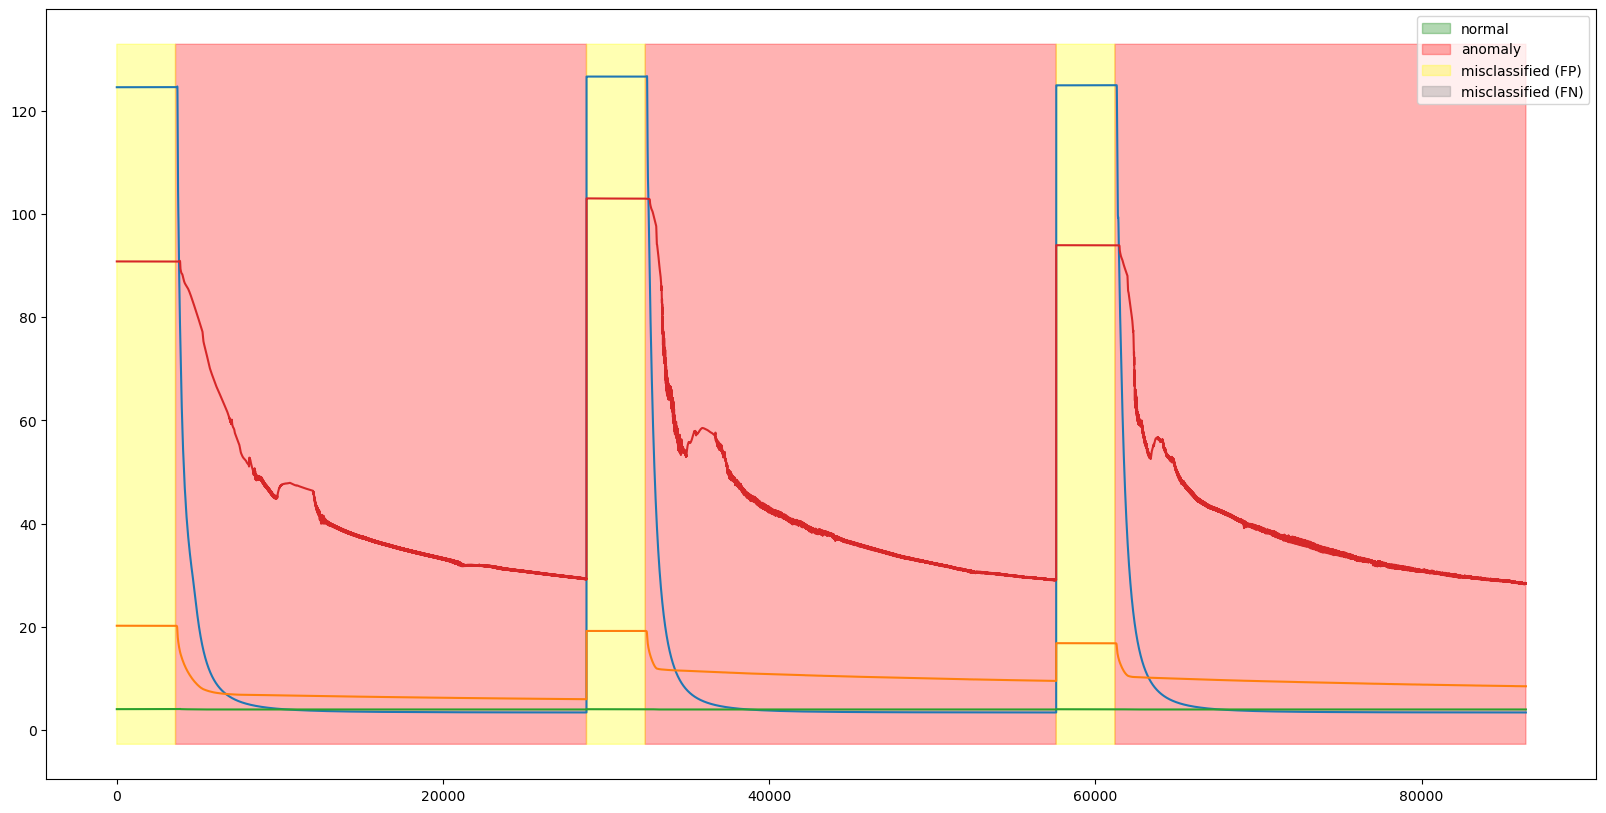

In [21]:
plt.figure(figsize=(20,10))
plt.plot(merged_data_test_np)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0,len(merged_data_test_np)), ymax, ymin, where=((~merged_data_test_class.astype(bool)) & (~pred)), color='green', alpha=0.3, label='normal')
plt.fill_between(np.arange(0,len(merged_data_test_np)), ymax, ymin,where=((merged_data_test_class.astype(bool)) & (pred)), color='red', alpha=0.3, label='anomaly')
plt.fill_between(np.arange(0,len(merged_data_test_np)), ymax, ymin,where=(~merged_data_test_class.astype(bool) & pred ), color='yellow', alpha=0.3, label='misclassified (FP)')
plt.fill_between(np.arange(0,len(merged_data_test_np)), ymax, ymin,where=(merged_data_test_class.astype(bool) & ~pred ), color='gray', alpha=0.3, label='misclassified (FN)')
# plt.legend(['P-PDG','P-TPT', 'T-TPT','P-PDG_rec','P-TPT_rec', 'T-TPT_rec','normal','anomaly','missclasiffied (FP)','missclasiffied (FN)'])
plt.legend()

## One-Class SVM

In [22]:
from sklearn.svm import OneClassSVM

scaler = pickle.load(open('StandardScaler-3W-0-filtered.pkl', 'rb'))
merged_data_np_scaled = scaler.transform(merged_data_np)

ocsvm = OneClassSVM()
ocsvm.fit(merged_data_np_scaled)

OneClassSVM()

In [23]:
scaler_test = pickle.load(open('StandardScaler-3W-2-filtered.pkl', 'rb'))
merged_data_test_np_scaled = scaler_test.transform(merged_data_test_np)

pred = ocsvm.predict(merged_data_test_np_scaled)
pred = np.where((pred == 1), 0, 1)

In [24]:
print("Accuracy: ", metrics.accuracy_score(np.array(merged_data_test_class).astype(bool), pred))
print("F1-score: ", metrics.f1_score(np.array(merged_data_test_class).astype(bool), pred))

Accuracy:  0.8749956595715129
F1-score:  0.933330864106078


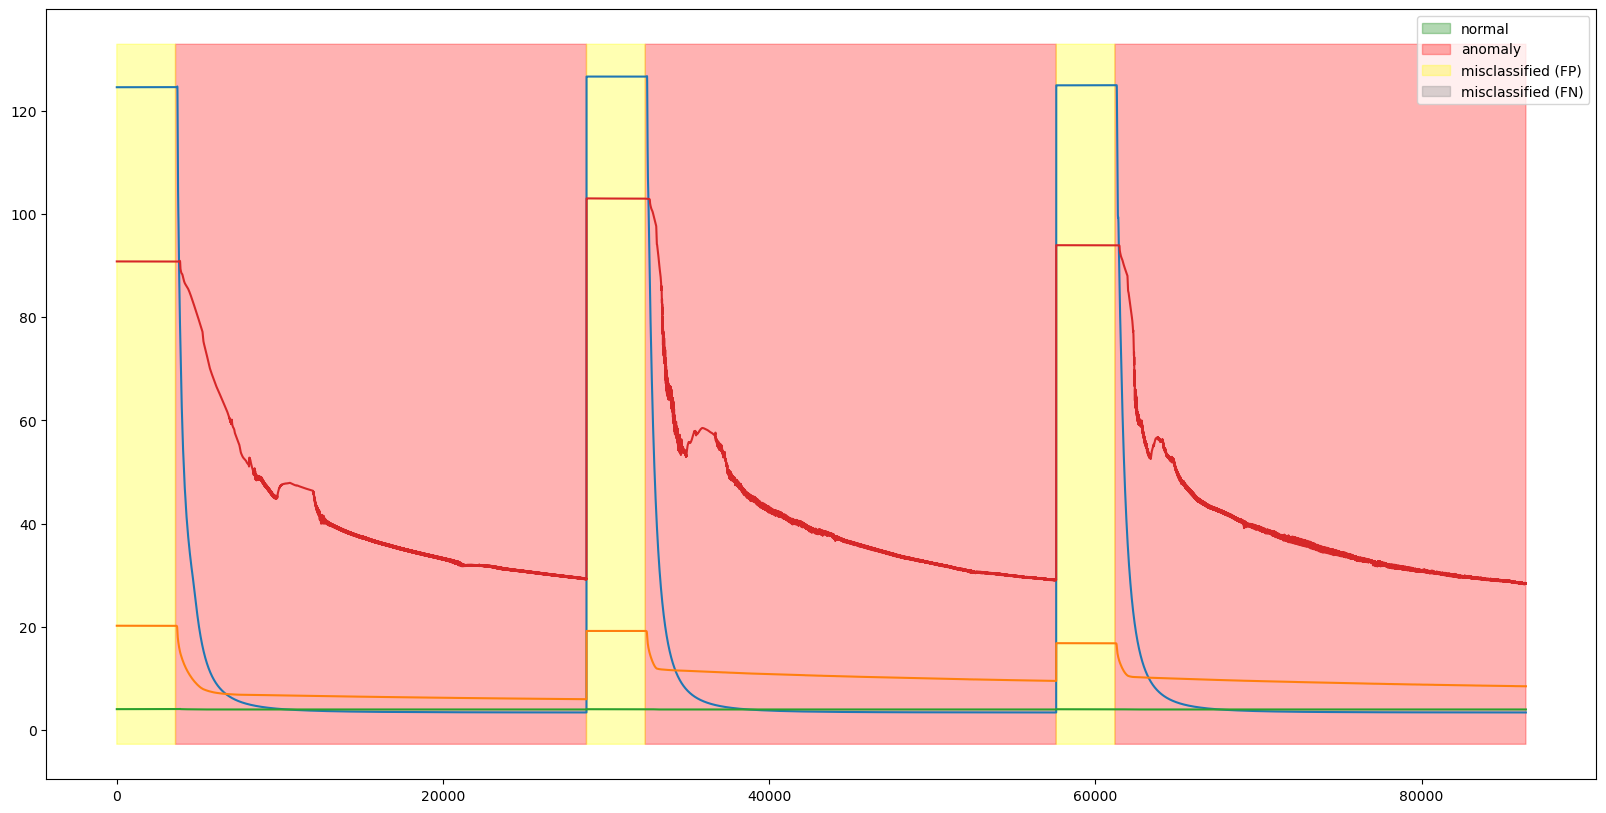

In [25]:
plt.figure(figsize=(20,10))
plt.plot(merged_data_test_np)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0,len(merged_data_test_np)), ymax, ymin, where=((~merged_data_test_class.astype(bool)) & (~pred)), color='green', alpha=0.3, label='normal')
plt.fill_between(np.arange(0,len(merged_data_test_np)), ymax, ymin,where=((merged_data_test_class.astype(bool)) & (pred)), color='red', alpha=0.3, label='anomaly')
plt.fill_between(np.arange(0,len(merged_data_test_np)), ymax, ymin,where=(~merged_data_test_class.astype(bool) & pred ), color='yellow', alpha=0.3, label='misclassified (FP)')
plt.fill_between(np.arange(0,len(merged_data_test_np)), ymax, ymin,where=(merged_data_test_class.astype(bool) & ~pred ), color='gray', alpha=0.3, label='misclassified (FN)')
# plt.legend(['P-PDG','P-TPT', 'T-TPT','P-PDG_rec','P-TPT_rec', 'T-TPT_rec','normal','anomaly','missclasiffied (FP)','missclasiffied (FN)'])
plt.legend()